In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
from keras.layers import Activation,Conv2D,MaxPooling2D,UpSampling2D,Dense,BatchNormalization,Input,Reshape,multiply,add,Dropout,AveragePooling2D,GlobalAveragePooling2D,concatenate
from keras.layers.convolutional import Conv2DTranspose
from keras.models import Model														  
import keras.backend as K
from keras.regularizers import l2
from keras.engine import Layer,InputSpec
from keras.utils import conv_utils
from keras.layers import Activation,Conv2D,MaxPooling2D,UpSampling2D,Dense,BatchNormalization,Input,Reshape,multiply,add,Dropout,AveragePooling2D,GlobalAveragePooling2D,concatenate
from keras.layers.convolutional import Conv2DTranspose
from keras.models import Model														  
import keras.backend as K
from keras.regularizers import l2
from keras.engine import Layer,InputSpec
from keras.utils import conv_utils


Using TensorFlow backend.


In [0]:
def BN_ReLU_Conv(inputs, n_filters, filter_size=3, dropout_p=0.2):

    '''Apply successivly BatchNormalization, ReLu nonlinearity, Convolution and Dropout (if dropout_p > 0)''' 
    l = BatchNormalization()(inputs)
    l = Activation('relu')(l)
    l = Conv2D(n_filters, filter_size, padding='same', kernel_initializer='he_uniform')(l)
    if dropout_p != 0.0:
      l = Dropout(dropout_p)(l)
    return l


def TransitionDown(inputs, n_filters, dropout_p=0.2):

  """ Apply first a BN_ReLu_conv layer with filter size = 1, and a max pooling with a factor 2  """
  l = BN_ReLU_Conv(inputs, n_filters, filter_size=1, dropout_p=dropout_p)
  l = MaxPooling2D((2,2))(l)
  return l

def TransitionUp(skip_connection, block_to_upsample, n_filters_keep):

    '''Performs upsampling on block_to_upsample by a factor 2 and concatenates it with the skip_connection'''

    #Upsample and concatenate with skip connection
    l = Conv2DTranspose(n_filters_keep, kernel_size=3, strides=2, padding='same', kernel_initializer='he_uniform')(block_to_upsample)
    l = concatenate([l, skip_connection], axis=-1)
    return l


def SoftmaxLayer(inputs, n_classes):
    """
    Performs 1x1 convolution followed by softmax nonlinearity
    The output will have the shape (batch_size  * n_rows * n_cols, n_classes)
    """
    l = Conv2D(n_classes, kernel_size=1, padding='same', kernel_initializer='he_uniform')(inputs)
#    l = Reshape((-1, n_classes))(l)
    l = Activation('softmax')(l)#or softmax for multi-class

    return l

In [0]:

def Tiramisu(

        input_shape=(240,240,3),

        n_classes = 3,

        n_filters_first_conv = 48,

        n_pool = 4,

        growth_rate = 16 ,

        n_layers_per_block =  [4, 4, 4 , 4, 4, 4, 4, 4, 4 ],

        dropout_p = 0.2

        ):

    if type(n_layers_per_block) == list:

            print(len(n_layers_per_block))

    elif type(n_layers_per_block) == int:

            n_layers_per_block = [n_layers_per_block] * (2 * n_pool + 1)

    else:

        raise ValueError

        

#####################

# First Convolution #

#####################        

    inputs = Input(shape=input_shape)

    stack = Conv2D(filters=n_filters_first_conv, kernel_size=3, padding='same', kernel_initializer='he_uniform')(inputs)

    n_filters = n_filters_first_conv



#####################

# Downsampling path #

#####################     

    skip_connection_list = []

    

    for i in range(n_pool):
        print("i")
        print(i)

        for j in range(n_layers_per_block[i]):
            print(j)
            l = BN_ReLU_Conv(stack, growth_rate, dropout_p=dropout_p)

            stack = concatenate([stack, l])

            n_filters += growth_rate

        

        skip_connection_list.append(stack)        

        stack = TransitionDown(stack, n_filters, dropout_p)

    skip_connection_list = skip_connection_list[::-1]



    

#####################

#    Bottleneck     #

#####################     

    block_to_upsample=[]

    

    for j in range(n_layers_per_block[n_pool]):

        l = BN_ReLU_Conv(stack, growth_rate, dropout_p=dropout_p)

        block_to_upsample.append(l)

        stack = concatenate([stack,l])

    block_to_upsample = concatenate(block_to_upsample)



   

#####################

#  Upsampling path  #

#####################

    for i in range(n_pool):

        n_filters_keep = growth_rate * n_layers_per_block[n_pool + i ]

        stack = TransitionUp(skip_connection_list[i], block_to_upsample, n_filters_keep)

        

        block_to_upsample = []

        for j in range(n_layers_per_block[ n_pool + i + 1 ]):

            l = BN_ReLU_Conv(stack, growth_rate, dropout_p=dropout_p)

            block_to_upsample.append(l)

            stack = concatenate([stack, l])

        block_to_upsample = concatenate(block_to_upsample)



#####################

#  Softmax          #

#####################

    output = SoftmaxLayer(stack, n_classes)            

    model=Model(inputs = inputs, outputs = output)    

    model.summary()

    

    return model

In [5]:
model = Tiramisu()

9



i
0
0








Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
1
2
3

i
1
0
1
2
3
i
2
0
1
2
3
i
3
0
1
2
3
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 240, 240, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 240, 240, 48) 1344        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 240, 240, 48) 192         conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (

In [0]:
import os
import cv2
import numpy as np

In [0]:
# Function to convert image from greyscale to one hot (i.e. 3 channels)
def convertToOneHot(image):
    num_classes = 3
    shape = image.shape[:2]+(num_classes,)
    encoded_image = np.zeros(shape, dtype=np.uint8)
    for r in range(len(image)):
      for c in range(len(image[0])):
        if image[r][c]==0:
          encoded_image[r][c][0] = 1
        elif image[r][c]==128:
          encoded_image[r][c][1] = 1
        else:
          encoded_image[r][c][2] = 1
    return encoded_image

In [0]:
# Function to convert back from one hot image to greyscale
def convertFromOneHot(image):
    shape = image.shape[:2]
    encoded_image = np.zeros(shape, dtype=np.uint8)
    for r in range(len(image)):
      for c in range(len(image[0])):
        if image[r][c][0] == 1:
          encoded_image[r][c] = 0
        elif image[r][c][1] == 1:
          encoded_image[r][c] = 128
        else:
          encoded_image[r][c] = 255
    return encoded_image

In [0]:
PATH = "/content/drive/My Drive/Breast Cancer Treatment/Numpy Arrays/3 Class"

# Train set patients: 230 232 239 242 
TrainX_1 = np.load(PATH + '/ER IHC 239 Images.npy')
TrainY_1 = np.load(PATH + '/ER IHC 239 Masks.npy')
TrainX_2 = np.load(PATH + '/ER IHC 232 Images.npy')
TrainY_2 = np.load(PATH + '/ER IHC 232 Masks.npy')
TrainX_3 = np.load(PATH + '/ER IHC 242 Images.npy')
TrainY_3 = np.load(PATH + '/ER IHC 242 Masks.npy')
TrainX_4 = np.load(PATH + '/ER IHC 230 Images.npy')
TrainY_4 = np.load(PATH + '/ER IHC 230 Masks.npy')

# Test set patients: 221 246 263
TestX_1 = np.load(PATH + '/ER IHC 221 Images.npy')
TestY_1 = np.load(PATH + '/ER IHC 221 Masks.npy')
TestX_2 = np.load(PATH + '/ER IHC 246 Images.npy')
TestY_2 = np.load(PATH + '/ER IHC 246 Masks.npy')
TestX_3 = np.load(PATH + '/ER IHC 263 Images.npy')
TestY_3 = np.load(PATH + '/ER IHC 263 Masks.npy')

In [10]:
TrainX_3.shape

(480, 240, 240, 3)

In [11]:
TrainX = np.concatenate((TrainX_1, TrainX_2, TrainX_3, TrainX_4), axis=0)
TrainGroundTruth = np.concatenate((TrainY_1, TrainY_2, TrainY_3, TrainY_4), axis=0)
TrainY = []

for img in TrainGroundTruth:
  encoded_img = convertToOneHot(img)
  TrainY.append(encoded_img)

TrainY = np.asarray(TrainY)

TestX = np.concatenate((TestX_1, TestX_2, TestX_3), axis=0)
TestGroundTruth = np.concatenate((TestY_1, TestY_2, TestY_3), axis=0)
TestY = []

for img in TestGroundTruth:
  encoded_img = convertToOneHot(img)
  TestY.append(encoded_img)

TestY = np.asarray(TestY)

ValidX = TrainX[1800:, : ]
ValidY = TrainY[1800:, : ]

TrainX = TrainX[0:1800, : ]
TrainY = TrainY[0:1800, : ]

print(TrainX.shape)
print(TrainY.shape)
print(TestX.shape)
print(TestY.shape)
print(ValidX.shape)
print(ValidY.shape)

(1800, 240, 240, 3)
(1800, 240, 240, 3)
(1440, 240, 240, 3)
(1440, 240, 240, 3)
(120, 240, 240, 3)
(120, 240, 240, 3)


In [0]:
TrainX = np.reshape(TrainX,(-1,240, 240,3))
TrainY = np.reshape(TrainY,(-1,240, 240,3))

TrainX = TrainX.astype('float32')/255

TestX = np.reshape(TestX,(-1,240, 240,3))
TestY = np.reshape(TestY,(-1,240, 240,3))

TestX = TestX.astype('float32')/255

ValidX = np.reshape(ValidX,(-1,240, 240,3))
ValidY = np.reshape(ValidY,(-1,240, 240,3))

ValidX = ValidX.astype('float32')/255

In [13]:
print(TrainX.shape)
print(TrainY.shape)
print(TestX.shape)
print(TestY.shape)

print(ValidX.shape)
print(ValidY.shape)

(1800, 240, 240, 3)
(1800, 240, 240, 3)
(1440, 240, 240, 3)
(1440, 240, 240, 3)
(120, 240, 240, 3)
(120, 240, 240, 3)


In [14]:
!pip install medpy
from keras.layers import *
import keras
from keras.models import Sequential
import cv2
import os
import matplotlib.pyplot as plt
%matplotlib inline
from medpy.metric import dc, precision, recall
from keras import Model
from keras.layers import (Input, Convolution2D, Activation, BatchNormalization,
                          merge, AveragePooling2D, GlobalAveragePooling2D,
                          Dense, Dropout)
from keras.regularizers import l2


     |████████████████████████████████| 153kB 2.7MB/s 
     |████████████████████████████████| 42.5MB 73kB/s 
  Created wheel for medpy: filename=MedPy-0.4.0-cp36-cp36m-linux_x86_64.whl size=753435 sha256=51c98bdab5f859cd4fa46175abcbdac5002e1a4f7ca2dc1e7fc3d792e47fc07a
  Stored in directory: /root/.cache/pip/wheels/8c/c9/9c/2c6281c7a72b9fb1570862a4f028af7ce38405008354fbf870
Successfully built medpy


In [0]:
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1)

In [0]:
def tversky_loss(y_true, y_pred):
    alpha = 0.5
    beta  = 0.5
    
    ones = K.ones(K.shape(y_true))
    p0 = y_pred      # proba that voxels are class i
    p1 = ones-y_pred # proba that voxels are not class i
    g0 = y_true
    g1 = ones-y_true
    
    num = K.sum(p0*g0, (0,1,2))
    den = num + alpha*K.sum(p0*g1,(0,1,2)) + beta*K.sum(p1*g0,(0,1,2))
    
    T = K.sum(num/den) # when summing over classes, T has dynamic range [0 Ncl]
    
    Ncl = K.cast(K.shape(y_true)[-1], 'float32')
    return Ncl-T

def combined_loss(y_true, y_pred):
  return (1*K.categorical_crossentropy(y_true, y_pred))+(0.5*tversky_loss(y_true, y_pred))

In [0]:
import math
from keras.callbacks import EarlyStopping,ModelCheckpoint
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=30)
mc = ModelCheckpoint('Checkpoint.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

In [0]:
optimizer=keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=True)

In [19]:
from keras import backend as K      
model.compile(loss=combined_loss, optimizer=optimizer, metrics=[dice_coef,'accuracy',tversky_loss])

In [20]:
num_epoch = 100;
MODELS_PATH = "/content/drive/My Drive/Breast Cancer Treatment/Models"
history = model.fit(TrainX, TrainY, epochs=num_epoch, validation_data=(ValidX, ValidY), shuffle=True,batch_size=4,callbacks=[es,mc])
model.save(MODELS_PATH + '/UNET_ER_20_03_17_4block.h5')

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 1800 samples, validate on 120 samples
Epoch 1/100
1800/1800 [==============================] - 129s 72ms/step - loss: 0.8520 - dice_coef: 0.9046 - acc: 0.9159 - tversky_loss: 1.1424 - val_loss: 0.9914 - val_dice_coef: 0.9786 - val_acc: 0.9865 - val_tversky_loss: 1.8931

Epoch 00001: val_loss improved from inf to 0.99144, saving model to Checkpoint.h5
Epoch 2/100
1800/1800 [==============================] - 108s 60ms/step - loss: 0.7619 - dice_coef: 0.9138 - acc: 0.9254 - tversky_loss: 1.0793 - val_loss: 0.9971 - val_dice_coef: 0.9847 - val_acc: 0.9886 - val_tversky_loss: 1.9097

Epoch 00002: val_loss did not improve from 0.99144
Epoch 3/100
1800/1800 [==============================] - 108s 60ms/step - loss: 0.6529 - dice_coef: 0.9270 - acc: 0.9377 - tversky_loss: 0.9086 - val_loss: 0.9762 - val_dice_coef: 0.9885 - val_acc: 0.9900 - val_tversky_loss: 1.8643

Epoch 00003: val_loss imp

In [24]:
from keras.models import load_model
MODELS_PATH = "/content/drive/My Drive/Breast Cancer Treatment/Models"
model = load_model(MODELS_PATH + '/UNET_ER_20_03_17_4block.h5', custom_objects={'combined_loss': combined_loss, 'dice_coef': dice_coef, 'tversky_loss': tversky_loss})

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where




In [0]:
train_loss = history.history['loss']
train_acc = history.history['acc']
val_loss = history.history['val_loss']
val_acc = history.history['val_acc']
xc=range(len(train_loss))
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(xc, train_loss)
plt.plot(xc, val_loss)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(['train','val'])

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(xc, train_acc)
plt.plot(xc, val_acc)
plt.xlabel("Epoch")
plt.ylabel("Acc")
plt.legend(['train','val'])

In [0]:
# MODELS_PATH = "/content/drive/My Drive/Breast Cancer Treatment/Models"
# model = keras.models.load_model(MODELS_PATH+'/UNET_ER_20_03_03_v5.h5',custom_objects={ 'combined_loss': combined_loss, 'dice_coef': dice_coef })

In [0]:
# Function to find the most probable class of an image pixel by pixel
def ClassFinder(img):
  result = np.zeros(img.shape, dtype=np.uint8)
  for r in range(len(img)):
    for c in range(len(img[0])):
      idx = np.argmax(img[r][c])
      result[r][c][idx]=1
      
  return result    

In [27]:
train_result = model.predict(TrainX, batch_size=4)
print(np.shape(train_result))
Train_predict = [ ]
for img in train_result:
  img = ClassFinder(img)
  encoded_img = convertFromOneHot(img)
  Train_predict.append(encoded_img)

Predicted_images = np.asarray(Train_predict)
print(Predicted_images.shape)
np.unique(Predicted_images)
# dice = dc(train_result, TrainY)
# pre  = precision(train_result,TrainY)
# re   = recall(train_result,TrainY)
# print('Train dc: '  + str(dice))
# print('Train pre: ' + str(pre))
# print('Train re: '  + str(re))

(1800, 240, 240, 3)
(1800, 240, 240)


array([  0, 128, 255], dtype=uint8)

In [28]:
test_result = model.predict(TestX, batch_size=4)
print(np.shape(test_result))

Test_predict = [ ]
for img in test_result:
  img = ClassFinder(img)
  encoded_img = convertFromOneHot(img)
  Test_predict.append(encoded_img)

Predicted_images_test = np.asarray(Test_predict)
print(Predicted_images_test.shape)
np.unique(Predicted_images_test)
# dice = dc(test_result, TestY)
# pre  = precision(test_result,TestY)
# re   = recall(test_result,TestY)
# print('Test dc: '  + str(dice))
# print('Test pre: ' + str(pre))
# print('Test re: '  + str(re))

(1440, 240, 240, 3)
(1440, 240, 240)


array([  0, 128, 255], dtype=uint8)

In [0]:
from sklearn.metrics import confusion_matrix
def get_confusion_matrix(Actual, Predicted):
  ActualY = np.reshape(Actual,(-1, Actual.shape[3]))
  PredY = np.reshape(Predicted,(-1, Predicted.shape[3]))
  matrix = confusion_matrix(ActualY.argmax(axis = 1), PredY.argmax(axis = 1))
  return matrix

def get_precision(confusion_matrix):
  precision = np.diag(confusion_matrix) / np.sum(confusion_matrix, axis = 0)
  nan_indices = np.isnan(precision)
  precision[nan_indices] = 0
  return precision

def get_recall(confusion_matrix):
  recall = np.diag(confusion_matrix) / np.sum(confusion_matrix, axis = 1)
  nan_indices = np.isnan(recall)
  recall[nan_indices] = 0
  return recall


In [30]:
test_matrix = get_confusion_matrix(TestY, test_result)
train_matrix = get_confusion_matrix(TrainY, train_result)
print(test_matrix)
print(train_matrix)
# TestY.shape[3]
# test_result.shape

[[71754151  1714682  2013662]
 [  112915   805596  2019879]
 [   28330    96163  4398622]]
[[87949146  1431790   668507]
 [ 1531975  4375928   237912]
 [  728862  2661285  4094595]]


In [31]:
np.unique(Predicted_images_test)

array([  0, 128, 255], dtype=uint8)

In [32]:
test_precision = get_precision(test_matrix)
print('Test Precision')
print(test_precision)
test_recall = get_recall(test_matrix)
print('Test Recall')
print(test_recall)
train_precision = get_precision(train_matrix)
print('Train Precision')
print(train_precision)
train_recall = get_recall(train_matrix)
print('Train Recall')
print(train_recall)

Test Precision
[0.99803541 0.30789764 0.52164812]
Test Recall
[0.95060651 0.27416238 0.97247627]
Train Precision
[0.97493806 0.51669931 0.81875296]
Train Recall
[0.97667618 0.71201753 0.54705894]


In [0]:
# weight_matrix = np.zeros((3,1))
# weight_matrix[0] = 0.6
# weight_matrix[1] = 0.2
# weight_matrix[2] = 0.2
# print(weight_matrix.shape)

In [34]:
weight_matrix = np.zeros((3,1))
weight_matrix[0] = 1/3
weight_matrix[1] = 1/3
weight_matrix[2] = 1/3
print(weight_matrix.shape)

(3, 1)


In [0]:
def get_overall_precision(precision, weights):
  final_precision = np.dot(precision,weights)
  return final_precision

def get_overall_recall(recall, weights):
  final_recall = np.dot(recall ,weights)
  return final_recall

In [36]:
final_test_precision  = get_overall_precision(test_precision, weight_matrix)
final_test_recall     = get_overall_recall(test_recall, weight_matrix)
final_train_precision = get_overall_precision(train_precision, weight_matrix)
final_train_recall    = get_overall_recall(train_recall, weight_matrix)
print('Final Test Precision')
print(final_test_precision)
print('Final Test Recall')
print(final_test_recall)
print('Final Train Precision')
print(final_train_precision)
print('Final Train Recall')
print(final_train_recall)

Final Test Precision
[0.60919372]
Final Test Recall
[0.73241505]
Final Train Precision
[0.77013011]
Final Train Recall
[0.74525088]


In [0]:
from scipy.stats import hmean

def dice_coefficient(precision, recall):
  return hmean(np.asarray([precision , recall]))
  

In [38]:
test_dice_coeff = dice_coefficient(final_test_precision, final_test_recall)
print('Test Dice coeff')
print(test_dice_coeff)

train_dice_coeff = dice_coefficient(final_train_precision, final_train_recall)
print('Train Dice coeff')
print(train_dice_coeff)

Test Dice coeff
[0.6651457]
Train Dice coeff
[0.75748626]


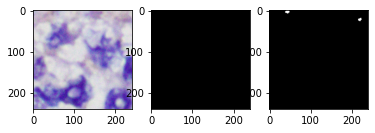

In [41]:
copy1  = np.copy(TestX [250])
copy2 = copy1.astype('float32')*255
copy2 = copy2.astype('uint8')
copy3 = np.reshape(copy2,(240, 240,3))
Img = cv2.cvtColor(copy3,cv2.COLOR_BGR2RGB)

Mask = TestGroundTruth[250]

Predicted_Mask = Predicted_images_test[250] 

plt.subplot(131).imshow(Img)
plt.subplot(132).imshow(Mask,'gray')
plt.subplot(133).imshow(Predicted_Mask,'gray')

In [0]:
def stitchMaskPatches(pieces):
  k = 0
  reconstructed_img = np.ones([1440,1920])
  for r in range(6):
    row = r * 240
    for c in range(8):
      col = c * 240
      reconstructed_img[row:row+240,col:col+240] = pieces[k]
      k = k + 1
  return reconstructed_img


def stitchImagePatches(pieces):
  k = 0
  reconstructed_img = np.ones([1440,1920,3])
  for r in range(6):
    row = r * 240
    for c in range(8):
      col = c * 240
      reconstructed_img[row:row+240,col:col+240,:] = pieces[k]
      k = k + 1
  return reconstructed_img


In [0]:
def saveNumpyOutput(mask):
  num = mask.shape[0]/480
  for id in range(int(num)):
    temp = []
    for i in range(id, id+10):
      idx = i * 48
      final_output = mask[idx:idx+48]
      final_output = stitchMaskPatches(final_output)
      temp.append(final_output)
    final_output = np.asarray(temp)
    np.save("/content/drive/My Drive/Breast Cancer Treatment/Numpy Arrays/Predicted Output/Combined_Loss/ER1 Patient " + str(id), final_output)

In [0]:
# saving predicted outputs as numpy arrays for test images
saveNumpyOutput(Predicted_images)

(48, 240, 240, 3)
(48, 240, 240)
(1440, 1920, 3)
(1440, 1920)
(1440, 1920)
[  0. 128. 255.]


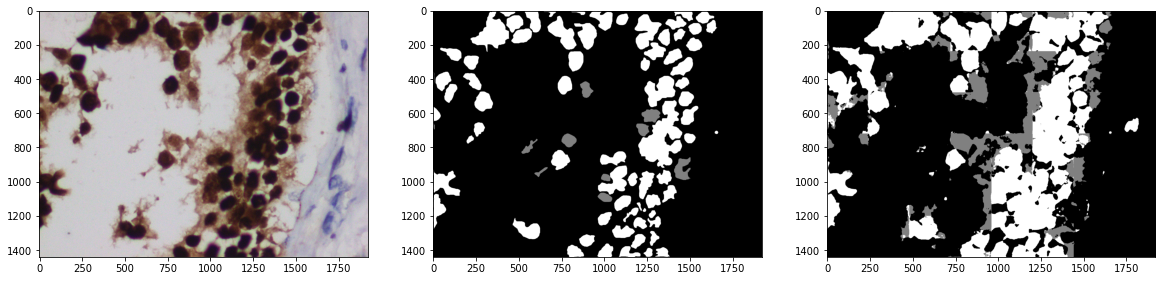

In [43]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow


plt.figure(figsize=(20,20))
id = 25   # enter between 0- 40 since there are 4 patients with 10 images each

id = id * 48
final_input = TestX[id:id+48]

Mask_input = TestY[id:id+48]
Test_Actual = [ ]
for img in Mask_input:
  img = ClassFinder(img)
  encoded_img = convertFromOneHot(img)
  Test_Actual.append(encoded_img)
  
print(Mask_input.shape)
Mask_input = np.asarray(Test_Actual)
print(Mask_input.shape)

final_output = Predicted_images_test[id:id+48]

final_input = stitchImagePatches(final_input)
Mask_input =  stitchMaskPatches(Mask_input)
final_output = stitchMaskPatches(final_output)

print(final_input.shape)
print(final_output.shape)
print(Mask_input.shape)

print(np.unique(final_output))
copy1  = np.copy(final_input)
copy2 = copy1.astype('float32')*255
copy2 = copy2.astype('uint8')
final_input = np.reshape(copy2,(1440, 1920,3))
final_input = cv2.cvtColor(final_input,cv2.COLOR_BGR2RGB)

plt.subplot(131).imshow(final_input)
plt.subplot(132).imshow(Mask_input,'gray')
plt.subplot(133).imshow(final_output,'gray')



(48, 240, 240, 3)
(48, 240, 240)
(1440, 1920, 3)
(1440, 1920)
(1440, 1920)
[  0. 128. 255.]


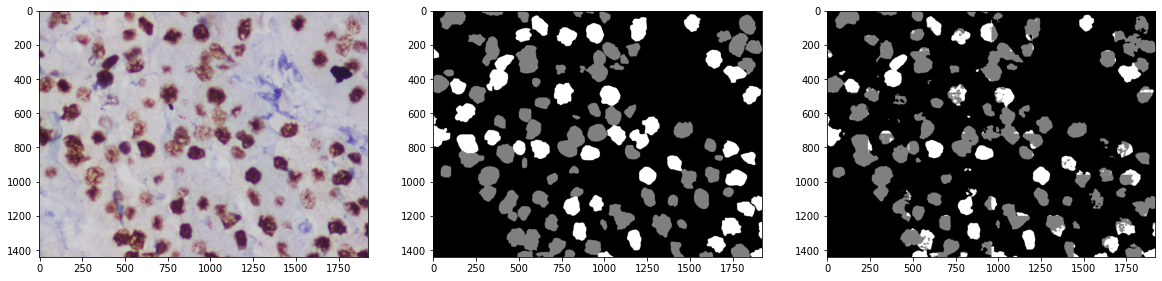

In [44]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow


plt.figure(figsize=(20,20))
id = 14  # enter between 0- 40 since there are 4 patients with 10 images each

id = id * 48
final_input = TrainX[id:id+48]

Mask_input = TrainY[id:id+48]
Train_Actual = [ ]
for img in Mask_input:
  img = ClassFinder(img)
  encoded_img = convertFromOneHot(img)
  Train_Actual.append(encoded_img)
  
print(Mask_input.shape)
Mask_input = np.asarray(Train_Actual)
print(Mask_input.shape)

final_output = Predicted_images[id:id+48]

final_input = stitchImagePatches(final_input)
Mask_input =  stitchMaskPatches(Mask_input)
final_output = stitchMaskPatches(final_output)

print(final_input.shape)
print(final_output.shape)
print(Mask_input.shape)

print(np.unique(final_output))
copy1  = np.copy(final_input)
copy2 = copy1.astype('float32')*255
copy2 = copy2.astype('uint8')
final_input = np.reshape(copy2,(1440, 1920,3))
final_input = cv2.cvtColor(final_input,cv2.COLOR_BGR2RGB)

plt.subplot(131).imshow(final_input)
plt.subplot(132).imshow(Mask_input,'gray')
plt.subplot(133).imshow(final_output,'gray')
